In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Tải dữ liệu
df = pd.read_csv('weather_data_danang.csv')
print("Dữ liệu gốc:")
print(f"shape: {df.shape}")
df.head()

Dữ liệu gốc:
shape: (17568, 11)


,time,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,rain,showers,snow_depth,weather_code,cloud_cover,wind_speed_10m
0,2024-01-01T00:00,23.0,89,21.1,1015.0,0.0,0.0,0.0,3,98,3.3
1,2024-01-01T01:00,22.5,92,21.0,1014.7,0.0,0.0,0.0,3,100,1.8
2,2024-01-01T02:00,22.4,92,21.0,1014.0,0.1,0.0,0.0,51,100,2.1
3,2024-01-01T03:00,22.6,90,20.9,1013.6,0.1,0.0,0.0,51,100,2.4
4,2024-01-01T04:00,22.5,90,20.8,1013.4,0.1,0.0,0.0,51,98,3.4


In [50]:
# --- 1. FEATURE ENGINEERING NÂNG CAO ---
# Sắp xếp thời gian để tạo đặc trưng trễ (Lag)
df['time'] = pd.to_datetime(df['time']) 
df = df.sort_values('time')

# A. Tạo các đặc trưng quá khứ (Lag Features) - Yếu tố quan trọng nhất cho Time Series
# "Thời tiết giờ trước" dự báo rất tốt cho "Thời tiết giờ này"
cols_to_lag = ['temperature_2m', 'relative_humidity_2m', 'surface_pressure', 'cloud_cover']
for col in cols_to_lag:
    df[f'{col}_lag1'] = df[col].shift(1) # Giá trị 1 giờ trước

# B. Tạo đặc trưng thời gian chu kỳ (Cyclical Features)
# Giúp mô hình hiểu 23h rất gần 0h, tháng 12 gần tháng 1
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# C. Chuyển đổi Target Group
def group_weather(code):
    if code <= 3: return 'Cloudy'
    if code <= 55: return 'Drizzle'
    if code <= 65: return 'Rain'
    return 'Storm/Other'

df['weather_group'] = df['weather_code'].apply(group_weather)

# Loại bỏ NaN (do shift) và các cột rác
df.dropna(inplace=True)
drop_cols = ['time', 'weather_code', 'weather_group', 'snow_depth', 'rain', 'showers']
cols_to_drop = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=cols_to_drop) 
y = df['weather_group']  

# Mã hóa nhãn
le = LabelEncoder() 
y_encoded = le.fit_transform(y)

print(f"Classes: {le.classes_}")
print(f"Features ({X.shape[1]}): {list(X.columns)}")

Classes: ['Cloudy' 'Drizzle' 'Rain']
Features (16): ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'temperature_2m_lag1', 'relative_humidity_2m_lag1', 'surface_pressure_lag1', 'cloud_cover_lag1', 'hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [51]:
# tạo weather_group để phân nhóm thời tiết và cho nó thành y 
if 'weather_group' not in df.columns:
    def group_weather(code):
        if code <= 3: return 'Cloudy'
        if code <= 55: return 'Drizzle'
        if code <= 65: return 'Rain'
        return 'Storm/Other'
    df['weather_group'] = df['weather_code'].apply(group_weather)
y = df['weather_group']

In [52]:
# Bước 1: Chia tập Train và tập tạm (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Bước 2: Chia tập tạm thành Validation và Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Shape Train: {X_train.shape}")
print(f"Shape Val: {X_val.shape}")
print(f"Shape Test: {X_test.shape}")

Shape Train: (12296, 16)
Shape Val: (2635, 16)
Shape Test: (2636, 16)


In [53]:
from sklearn.preprocessing import PolynomialFeatures

# 3. Scaling & Polytechnic Features (Tạo tương tác phi tuyến)
# Softmax là mô hình tuyến tính, nó cần PolynomialFeatures để học được các mối quan hệ phức tạp
# Ví dụ: Mưa thường xảy ra khi "Độ ẩm cao" VÀ "Nhiệt độ giảm" (Tương tác Humidity * Temperature)

print("Đang tạo đặc trưng tương tác (Polynomial Features)...")
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

# Scale dữ liệu sau khi tạo poly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

print(f"Số lượng đặc trưng sau khi mở rộng: {X_train_scaled.shape[1]}")

Đang tạo đặc trưng tương tác (Polynomial Features)...
Số lượng đặc trưng sau khi mở rộng: 136


In [54]:
from sklearn.model_selection import GridSearchCV

# 4. Tối ưu hóa Hyperparameters để đạt Accuracy cao nhất
# Sử dụng Grid Search để tìm tham số C (Regularization) tốt nhất

param_grid = {
    'C': [0.1, 1, 10, 100], # C càng lớn càng ít Regularization (mô hình phức tạp hơn, có thể fit tốt hơn)
    'solver': ['lbfgs', 'newton-cg'], 
    # Mẹo: Để Accuracy cao nhất, ta thường KHÔNG dùng 'balanced' nếu tập dữ liệu lệch
    # Vì 'balanced' sẽ hy sinh Accuracy của lớp đa số để cứu lớp thiểu số.
    # Ta để GridSearch tự quyết định xem có nên dùng class_weight hay không.
    'class_weight': [None, 'balanced'] 
}

grid = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy', # Mục tiêu tối thượng là Accuracy
    n_jobs=-1
)

print("Đang tìm kiếm tham số tối ưu (Grid Search)...")
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
print(f"Tham số tốt nhất: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# Gán lại model để dùng cho cell dự đoán bên dưới
model = best_model

Đang tìm kiếm tham số tối ưu (Grid Search)...


c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Tham số tốt nhất: {'C': 100, 'class_weight': None, 'solver': 'newton-cg'}
Best CV Accuracy: 0.7977


--- BÁO CÁO CHI TIẾT TRÊN TẬP TEST ---
              precision    recall  f1-score   support

      Cloudy       0.84      0.91      0.87      1751
     Drizzle       0.66      0.55      0.60       727
        Rain       0.70      0.53      0.60       158

    accuracy                           0.79      2636
   macro avg       0.73      0.66      0.69      2636
weighted avg       0.78      0.79      0.78      2636

Độ chính xác trên tập Train: 0.8078
Độ chính xác trên tập Test: 0.7898


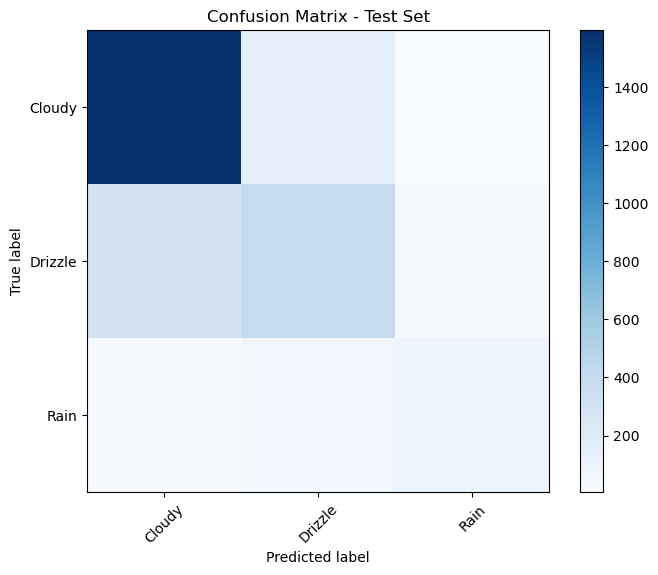

In [56]:
# Dự đoán trên tập Test (Dữ liệu mô hình chưa bao giờ thấy)

y_test_pred = model.predict(X_test_scaled)

print("--- BÁO CÁO CHI TIẾT TRÊN TẬP TEST ---")
# Sử dụng target_names lấy từ le.classes_ để hiển thị tên nhóm (Cloudy, Rain...) thay vì số 0, 1...
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Dự đoán trên tập Train 
y_train_pred = model.predict(X_train_scaled)
print(f"Độ chính xác trên tập Train: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Độ chính xác trên tập Test: {accuracy_score(y_test, y_test_pred):.4f}")

# In ra ma trận nhầm lẫn cho tập Test bằng matplotlib
import matplotlib.pyplot as plt 
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
# Cập nhật nhãn trục X, Y theo tên nhóm
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()